## Section2 Part1 Export the Statistics of different length eccDNA & copy numebr amplified ecDNA
#### Ke Liu

In [1]:
import subprocess as sp
import pandas as pd
import pysam as ps
import numpy as np
from scipy import stats 
import scipy as sci
from tqdm import tqdm
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.font_manager as font_manager
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
font_manager.fontManager.addfont('/home/qukun/liuke/miniconda3/fonts/Arial.ttf')
mpl.rcParams["font.sans-serif"] = "Arial"
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.serif'] = ['Arial']

### 1. Filter the results and transit into BED format

In [2]:
all_protocols = ['ATAC','DNAT' ,'DSAT', 'DNARCAT', 'DNARCAU', 'DSARCAT', 'DSARCAU', 'DNRT7', 'DSRT7', 'Nanopore_WGS', 'NGS_WGS' ]
methods = ['WGS-SR', 'WGS-LR', 'ATAC', '3SEP-SR', '3SEP-LR', 'Circle-seq-SR', 'Circle-seq-LR']
protocols = ['NGS_WGS', 'Nanopore_WGS', 'ATAC', 'DSAT', 'DSRT7', 'DNARCAU', 'DNRT7']
samples = ['{0}{1}'.format(a,b) for a in protocols for b in [1,2,3]]
methods_protocols = {'Circle-Seq-SR':'DNARCAU', '3SEP-SR':'DSARCAT', 'Circle-Seq-LR':'DNRT7', '3SEP-LR':'DSRT7', 'ATAC':'ATAC', 'WGS-SR':'NGS_WGS', 'WGS-LR':'Nanopore_WGS'}
protocols_methods = dict(zip(protocols, methods))
palette= {'Circle-seq-LR':'#ef6398', 'Circle-seq-SR':'#f9b035', '3SEP-LR':'#e35f5f', '3SEP-SR':'#fedd04', 'ATAC':'#52b97f','WGS-LR': '#3bb3cf', 'WGS-SR': '#377fb2'}
NGS_methods = ['NGS_WGS','ATAC','DSAT','DNARCAU']
Nanopore_methods = ['Nanopore_WGS', 'DSRT7', 'DNRT7']

In [3]:
## Circle-MAP
circle_map_protocols = ['DNARCAU', 'DNARCAT', 'DSARCAT', 'DSARCAU', 'DSAT', 'DNAT']
circle_map_samples = ['{0}{1}'.format(a,b) for a in circle_map_protocols for b in [1,2,3]]
for sample in circle_map_samples:
    locals()[sample] = pd.read_csv('/home/qukun/liuke/workspace/benchmark/result/2nd/raw/'+sample+'.circle.bed', delimiter='\t', names=['Chromosome','Start','End','Discordants','Splits','Score','Coverage','Std','Cov_Start','Cov_End','Coverage_Continuity'])
    locals()[sample].insert(3,'ID',['ec{0}'.format(num) for num in range(1,len(locals()[sample])+1)])
    locals()[sample].insert(4,'Reads',locals()[sample].Splits+locals()[sample].Discordants)
    locals()[sample].insert(locals()[sample].shape[1],'Length',locals()[sample].End-locals()[sample].Start+1)
    locals()[sample] = locals()[sample][(locals()[sample]['Score']>50) & 
                                              (locals()[sample]['Cov_Start']>0.33) &
                                              (locals()[sample]['Cov_End']>0.33) &
                                              (locals()[sample]['Coverage_Continuity']<0.1) &
                                              (locals()[sample]['Coverage']>0.5) & 
                                              (locals()[sample]['Length']<1e7) & 
                                              (locals()[sample]['Splits']>2) & 
                                              (locals()[sample]['Discordants']>2)
    ]
    locals()[sample][['Chromosome', 'Start', 'End', 'ID', 'Reads', 'Coverage', 'Length']].to_csv('/home/qukun/liuke/workspace/benchmark/result/2nd/filtered/'+sample+'.bed', index=None, header=None, sep='\t')

In [4]:
## Circle_finder
circle_finder_protocols = ['ATAC']
circle_finder_samples = ['{0}{1}'.format(a,b) for a in circle_finder_protocols for b in [1,2,3]]
for sample in circle_finder_samples:
    locals()[sample] = pd.read_csv('/home/qukun/liuke/workspace/benchmark/result/2nd/raw/'+sample+'-hg38.microDNA-JT.txt', delimiter='\t', names=['Chromosome','Start','End','Reads'])
    locals()[sample].insert(3,'ID',['ec{0}'.format(num) for num in range(1,len(locals()[sample])+1)])
    locals()[sample].insert(locals()[sample].shape[1],'Coverage',0)
    locals()[sample].insert(locals()[sample].shape[1],'Length',locals()[sample].End-locals()[sample].Start+1)
    locals()[sample] = locals()[sample][locals()[sample]['Length']<1e7]
    locals()[sample].to_csv('/home/qukun/liuke/workspace/benchmark/result/2nd/filtered/'+sample+'.bed', index=None, header=None, sep='\t')

In [5]:
## AmpliconArchitect
AmpliconArchitect_protocols = ['NGS_WGS']
AmpliconArchitect_samples = ['{0}{1}'.format(a,b) for a in AmpliconArchitect_protocols for b in [1,2,3]]
for sample in AmpliconArchitect_samples:
    temp = pd.read_csv('/home/qukun/liuke/workspace/benchmark/result/2nd/raw/'+sample+'_result_table.tsv', sep='\t')
    temp = temp[temp['Classification']=='ecDNA']
    locals()[sample] = pd.DataFrame(columns=['Chromosome', 'Start', 'End', 'ID', 'Reads', 'Coverage', 'Length'])
    for i in temp.index:
        for loc in temp.loc[i,'Location'].split("'"):
            if 'chr' in loc:
                locals()[sample] = pd.concat([locals()[sample],pd.DataFrame({'Chromosome':loc.split(':')[0],
                                                                            'Start':loc.split(':')[1].split('-')[0],
                                                                            'End':loc.split(':')[1].split('-')[1],
                                                                            'ID':temp.loc[i,'Feature ID'],
                                                                            'Reads':0,
                                                                            'Coverage':temp.loc[i,'Feature median copy number'],
                                                                            'Length':temp.loc[i,'Captured interval length']},index=[0])])
    del temp
    locals()[sample] = locals()[sample].reset_index().drop('index',axis=1)
    locals()[sample].to_csv('/home/qukun/liuke/workspace/benchmark/result/2nd/filtered/'+sample+'.bed', index=None, header=None, sep='\t')

In [6]:
## CReSIL
CReSIL_protocols = ['DNRT7', 'DSRT7', 'Nanopore_WGS']
CReSIL_samples = ['{0}{1}'.format(a,b) for a in CReSIL_protocols for b in [1,2,3]]
for sample in CReSIL_samples:
    temp = pd.read_csv('/home/qukun/liuke/workspace/benchmark/result/3rd/raw/'+sample+'.txt', sep='\t')
    temp = temp[temp['eccdna_status']=='cyclic']
    locals()[sample] = pd.DataFrame(columns=['Chromosome', 'Start', 'End', 'ID', 'Reads', 'Coverage', 'Length'])
    for i in tqdm(temp.index):
        for loc in temp.loc[i,'merge_region'].split(","):
            locals()[sample] = pd.concat([locals()[sample],pd.DataFrame({'Chromosome':loc.split(':')[0],
                                                                        'Start':loc.split(':')[1].split('-')[0],
                                                                        'End':loc.split(':')[1].split('-')[1].split('_')[0],
                                                                        'ID':temp.loc[i,'id'],
                                                                        'Reads':temp.loc[i,'numreads'],
                                                                        'Coverage':temp.loc[i,'coverage'],
                                                                        'Length':temp.loc[i,'merge_len']},index=[0])])
    del temp
    locals()[sample] = locals()[sample].reset_index().drop('index',axis=1)
    locals()[sample].to_csv('/home/qukun/liuke/workspace/benchmark/result/3rd/filtered/'+sample+'.bed', index=None, header=None, sep='\t')

100%|██████████| 160/160 [00:00<00:00, 718.97it/s]


### 2. Calculate the Statiistics of Experiment

In [7]:
total_table = pd.DataFrame(index=['{0}{1}'.format(a, b) for a in protocols for b in [1,2,3]],columns=['eccDNA','Datasize','ecDNA','<2kb', '2kb-10kb', '>10kb', 'ec<2kb', 'ec2kb-10kb', 'ec>10kb', 'nonec<2kb', 'nonec2kb-10kb', 'nonec>10kb'])

#### 2.0 Statistics of fastq  
Using seqkit to count the base of raw fastq per sample and store in fastq_sum.txt

###### PBS Script to run seqkit

In [8]:
fastq_stats = pd.read_csv('/home/qukun/liuke/workspace/benchmark/data/exp/summary.txt',header=None, sep='\t')

In [9]:
title = [i for i in fastq_stats.iloc[0][0].split(' ') if (i!='')]
fastq_stat_table = pd.DataFrame(columns=title)
for i in fastq_stats.index[1:]:
    value = [i for i in fastq_stats.iloc[i][0].split(' ') if (i!='')]
    fastq_stat_table = pd.concat([fastq_stat_table,pd.DataFrame(dict(zip(title,value)),index=[0])])
fastq_stat_table = fastq_stat_table.reset_index().drop('index',axis=1)
fastq_stat_table[title[3:]] = fastq_stat_table[title[3:]].applymap(lambda x: x.replace(',','')).astype(float)

#### 2.1 Classify the eccDNA with Length information

In [10]:
## 对于长度进行区分
bins = [0, 2000, 1e4, 1e7]
labels = ['0-2kb','2-10kb','>10kb']
for sample in ['{0}{1}'.format(a, b) for a in all_protocols for b in [1,2,3]]:
    locals()[sample].insert(locals()[sample].shape[1],'Type_Len',pd.cut(locals()[sample]['Length'], bins, labels = labels))

In [11]:
## 统计eccDNA总数
for sample in tqdm(samples):
    total_table.loc[sample,['eccDNA','Datasize','<2kb', '2kb-10kb', '>10kb']] = [len(locals()[sample]['ID'].unique()),
                                                                                 fastq_stat_table[fastq_stat_table['file'].str.contains(sample)]['sum_len'].sum()/10**9,
                                                                                 len(locals()[sample][locals()[sample]['Type_Len']=='0-2kb']['ID'].unique()),
                                                                                 len(locals()[sample][locals()[sample]['Type_Len']=='2-10kb']['ID'].unique()),
                                                                                 len(locals()[sample][locals()[sample]['Type_Len']=='>10kb']['ID'].unique())]

100%|██████████| 21/21 [00:00<00:00, 81.48it/s]


#### 2.2 Classify the eccDNA with Copy Number Amplification

In [12]:
def intersect(a,b,command,result):
    _shell2call = '/home/qukun/liuke/miniconda3/envs/eccDNA/bin/bedtools intersect -nonamecheck -a {0} -b {1} {2} > {3}'.format(a, b, command, result)
    sp.check_call(_shell2call, shell=True)
    return result

##### Step1 CNA intersection of 3 replicates

In [13]:
CNA_path = '/home/qukun/liuke/workspace/benchmark/result/CNA/'
for i in range(1,4):
    locals()['CNV%s'%i] = pd.read_csv(CNA_path+'ControlFreec/Nanopore_WGS%i.bam_CNVs'%i,
                                       sep='\t',
                                       names=['Chromosome','Start','End','Value','CNV'])
    locals()['CNV%s'%i].Chromosome = locals()['CNV%s' %i].apply(lambda x: 'chr%s'%x.Chromosome,axis=1)
    locals()['CNV%s'%i] = locals()['CNV%s'%i][locals()['CNV%s'%i].CNV=='gain']
    locals()['CNV%s'%i].to_csv(CNA_path+'CNV%s.bed'%i,sep='\t',index=None,header=None)
intersect(CNA_path+'CNV1.bed', CNA_path+'CNV2.bed', '', CNA_path+'CNV12.bed')
intersect(CNA_path+'CNV12.bed', CNA_path+'CNV3.bed', '', CNA_path+'CNA.bed')
sp.check_call('rm '+CNA_path+'CNV12.bed ',shell=True)

0

##### Step2 generate ecDNA bed files

In [14]:
NGS_path = '/home/qukun/liuke/workspace/benchmark/result/2nd/filtered/'
for sample in ['{0}{1}'.format(a, b) for a in NGS_methods for b in [1,2,3]]:

    result_bed = NGS_path+sample+'.bed'
    intersect_bed = '/home/qukun/liuke/workspace/benchmark/result/CNA/ecDNA/'+sample+'.bed'
    intersect(result_bed, CNA_path+'CNA.bed', '-wa -wb', intersect_bed)
    
    locals()[sample+'_intersect'] = pd.read_csv(intersect_bed,sep='\t',header=None)
    locals()[sample] = pd.read_csv(result_bed,sep='\t',header=None,names=['Chromosome','Start','End','ID','Reads','Coverage','Length'])
    locals()[sample].insert(locals()[sample].shape[1],'Type_Len',pd.cut(locals()[sample]['Length'], bins, labels = labels))
        
    total_table.loc[sample,'eccDNA'] = len(locals()[sample]['ID'].unique())
    total_table.loc[sample,'ecDNA'] = len(locals()[sample+'_intersect'][3].unique())
    total_table.loc[sample,['ec<2kb', 'ec2kb-10kb', 'ec>10kb']] = [len(locals()[sample][(locals()[sample].ID.isin(locals()[sample+'_intersect'][3].unique()))&(locals()[sample]['Type_Len']=='0-2kb')]['ID'].unique()),
                                                                   len(locals()[sample][(locals()[sample].ID.isin(locals()[sample+'_intersect'][3].unique()))&(locals()[sample]['Type_Len']=='2-10kb')]['ID'].unique()),
                                                                   len(locals()[sample][(locals()[sample].ID.isin(locals()[sample+'_intersect'][3].unique()))&(locals()[sample]['Type_Len']=='>10kb')]['ID'].unique())]
    
    locals()[sample+'_ecDNA_bed'] = locals()[sample][locals()[sample].ID.isin(set(locals()[sample+'_intersect'][3].unique()))]
    locals()[sample+'_ecDNA_bed'].drop_duplicates().to_csv('/home/qukun/liuke/workspace/benchmark/result/CNA/ecDNA/'+sample+'.ecDNA.bed',sep='\t',index=None,header=None)

        
Nanopore_path = '/home/qukun/liuke/workspace/benchmark/result/3rd/filtered/'
for sample in ['{0}{1}'.format(a, b) for a in Nanopore_methods for b in [1,2,3]]:
        
        result_bed = Nanopore_path+sample+'.bed'
        intersect_bed = '/home/qukun/liuke/workspace/benchmark/result/CNA/ecDNA/'+sample+'.bed'
        intersect(result_bed, CNA_path+'CNA.bed', '-wa -wb', intersect_bed)
        
        locals()[sample+'_intersect'] = pd.read_csv(intersect_bed,sep='\t',header=None)
        locals()[sample] = pd.read_csv(result_bed,sep='\t',header=None,names=['Chromosome','Start','End','ID','Reads','Coverage','Length'])
        locals()[sample].insert(locals()[sample].shape[1],'Type_Len',pd.cut(locals()[sample]['Length'], bins, labels = labels))
        
        total_table.loc[sample,'eccDNA'] = len(locals()[sample]['ID'].unique())
        total_table.loc[sample,'ecDNA'] = len(locals()[sample+'_intersect'][3].unique())
        total_table.loc[sample,['ec<2kb', 'ec2kb-10kb', 'ec>10kb']] = [len(locals()[sample][(locals()[sample].ID.isin(locals()[sample+'_intersect'][3].unique()))&(locals()[sample]['Type_Len']=='0-2kb')]['ID'].unique()),
                                                                       len(locals()[sample][(locals()[sample].ID.isin(locals()[sample+'_intersect'][3].unique()))&(locals()[sample]['Type_Len']=='2-10kb')]['ID'].unique()),
                                                                       len(locals()[sample][(locals()[sample].ID.isin(locals()[sample+'_intersect'][3].unique()))&(locals()[sample]['Type_Len']=='>10kb')]['ID'].unique())]
        locals()[sample+'_ecDNA_bed'] = locals()[sample][locals()[sample].ID.isin(set(locals()[sample+'_intersect'][3].unique()))]
        locals()[sample+'_ecDNA_bed'].drop_duplicates().to_csv('/home/qukun/liuke/workspace/benchmark/result/CNA/ecDNA/'+sample+'.ecDNA.bed',sep='\t',index=None,header=None)

In [15]:
total_table['nonec<2kb'] = total_table['<2kb'] - total_table['ec<2kb']
total_table['nonec2kb-10kb'] = total_table['2kb-10kb'] - total_table['ec2kb-10kb']
total_table['nonec>10kb'] = total_table['>10kb'] - total_table['ec>10kb']

In [16]:
total_table.to_csv('/home/qukun/liuke/workspace/benchmark/Figure/Total_Experiment_statistics.csv',sep='\t')

### 3 Viusalize the correlation of copy number and eccDNA coverage

#### 3.1 Calculate the depth of eccDNA of different methods using bedtools depth

In [21]:
def Mean_Depth_Bed(bam_file, bed_file):
    # Open the BAM file
    bam = ps.AlignmentFile(bam_file, 'rb')
    # Initialize dictionary to store mean depths for each region
    result = pd.DataFrame(columns=['Chromosome','Start','End','ID','Reads','Coverage','Length','Mean_Depth'])
    # Iterate through regions in the BED file
    i=0
    with open(bed_file, 'r') as bed:
        for line in bed:
            if not line.strip() or line.startswith("#"):
                continue
            row = line.strip().split('\t')[:-1]
            chrom, start, end = row[:3]
            start, end = int(start), int(end)
            # Initialize variables to calculate depth and base count
            depth_sum = 0
            base_count = 0
            # Iterate through reads overlapping the region
            for read in bam.fetch(chrom, start, end):
                # Calculate the overlap with the region
                if read.reference_start is None or read.reference_end is None:
                    continue
                overlap_start = max(start, read.reference_start)
                overlap_end = min(end, read.reference_end)
                overlap_length = max(0, overlap_end - overlap_start)

                # Increment depth sum and base count
                depth_sum += overlap_length
                base_count += (overlap_end - overlap_start)
            # Calculate mean depth for the region
            mean_depth = depth_sum / (end - start + 1) if (end - start + 1) > 0 else 0
            # Store mean depth in the dictionary
            result.loc[i] = row +[mean_depth]
            i+=1
    # Close the BAM file
    bam.close()
    return result

In [22]:
for sample in NGS_methods:
    for i in tqdm(range(1,4)):
        bed_file = '/home/qukun/liuke/workspace/benchmark/result/CNA/ecDNA/%s%i.ecDNA.bed'%(sample,i)
        bam_file = '/home/qukun/liuke/workspace/benchmark/result/2nd/bam/%s%i.bam'%(sample,i)
        locals()['%s%i_coverage_correct'%(sample,i)] = Mean_Depth_Bed(bam_file, bed_file)

100%|██████████| 3/3 [02:31<00:00, 50.35s/it]


In [25]:
for sample in Nanopore_methods:
    for i in tqdm(range(1,4)):
        bed_file = '/home/qukun/liuke/workspace/benchmark/result/CNA/ecDNA/%s%i.ecDNA.bed'%(sample,i)
        bam_file = '/home/qukun/liuke/workspace/benchmark/result/3rd/bam/%s%i.bam'%(sample,i)
        locals()['%s%i_coverage_correct'%(sample,i)] = Mean_Depth_Bed(bam_file, bed_file)

100%|██████████| 3/3 [04:50<00:00, 96.83s/it] 


In [26]:
for sample in protocols:
    for i in range(1,4):
        locals()['%s%i_coverage_correct'%(sample,i)].to_csv('/home/qukun/liuke/workspace/benchmark/result/CNA/ecDNA/%s%i.ecDNA.coverage_correct'%(sample,i),sep='\t')

100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


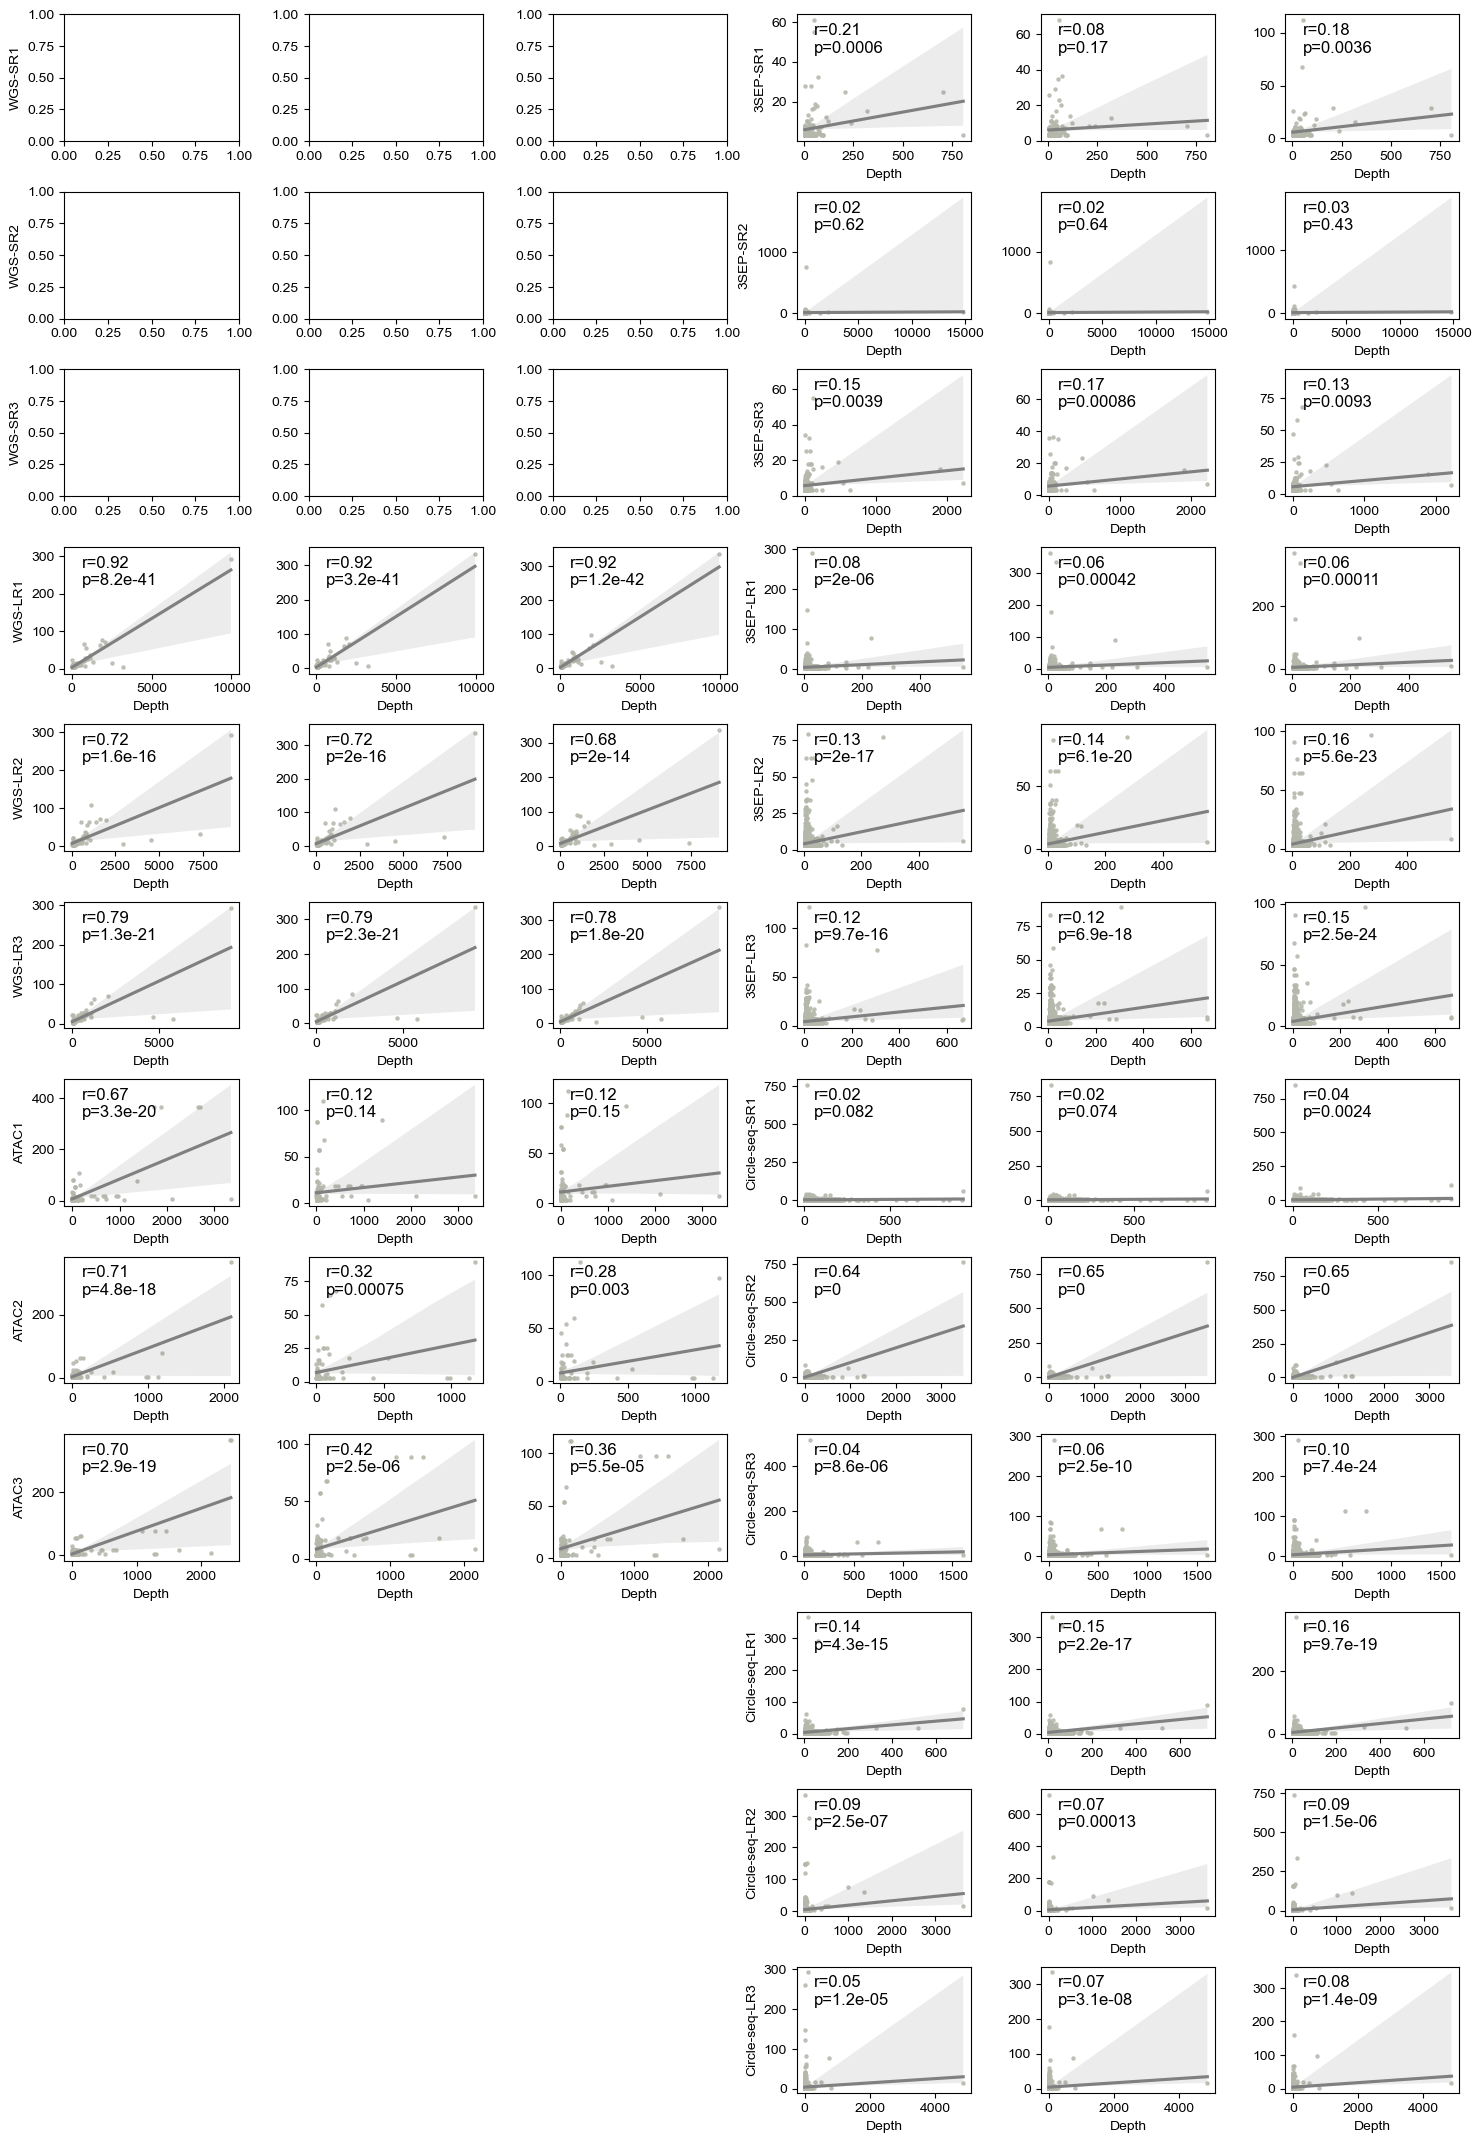

In [27]:
fig = plt.figure(figsize=(18,27))
subplot = gs.GridSpec(12, 6,height_ratios=[1,1,1,1,1,1,1,1,1,1,1,1],width_ratios=[1,1,1,1,1,1],hspace=0.4,wspace=0.4)
for n in range(3):
    method=['NGS_WGS','Nanopore_WGS','ATAC'][n]
    for i in tqdm(range(1,4)):
        for j in range(1,4):
            locals()['ax%i%i'%(j,3*n+i)] = fig.add_subplot(subplot[3*n+i-1,j-1])
            test = pd.read_csv('/home/qukun/liuke/workspace/benchmark/result/CNA/ControlFreec/relation/'+method+str(i)+'.'+str(j)+'.bed',sep='\t',header=None) 
            test = test.groupby(by=[3]).mean([7,14])
            test = pd.concat([locals()['%s%i_coverage_correct'%(method,i)].groupby(['ID']).mean(['Mean_Depth']),test],axis=1)
            test.columns=['Depth',1,2,4,5,6,7,8,9,10,12,13,'CopyN']
            test=test[(test.CopyN<500)&(test.Depth<10000)]
            if len(test)>2:
                sns.regplot(test,x='Depth',y='CopyN',color='#B4B8AB',ax=locals()['ax%i%i'%(j,3*n+i)],scatter_kws={'s': 5},line_kws={'color': 'gray'})
                locals()['ax%i%i'%(j,3*n+i)].set_rasterized(True)
                r, p = sci.stats.pearsonr(test['Depth'], test['CopyN'])
                locals()['ax%i%i'%(j,3*n+i)].text(.1, .7, 'r={:.2f}\np={:.2g}'.format(r, p),transform=locals()['ax%i%i'%(j,3*n+i)].transAxes, fontsize=12, color='black', weight='semibold')
            else:
                sns.scatterplot(test,x='Depth',y='CopyN',color='#B4B8AB',ax=locals()['ax%i%i'%(j,3*n+i)],**{'s': 10})
                locals()['ax%i%i'%(j,3*n+i)].set_rasterized(True)
            if j==1:
                locals()['ax%i%i'%(j,3*n+i)].set_ylabel(protocols_methods[method]+str(i))
            else:
                locals()['ax%i%i'%(j,3*n+i)].set_ylabel('')

for n in range(4):
    method=['DSAT', 'DSRT7', 'DNARCAU', 'DNRT7'][n]
    for i in tqdm(range(1,4)):
        for j in range(1,4):
            locals()['ax%i%i'%(j,3*n+i)] = fig.add_subplot(subplot[3*n+i-1,j+2])
            test = pd.read_csv('/home/qukun/liuke/workspace/benchmark/result/CNA/ControlFreec/relation/'+method+str(i)+'.'+str(j)+'.bed',sep='\t',header=None) 
            test = test.groupby(by=[3]).mean([7,14])
            test = pd.concat([locals()['%s%i_coverage_correct'%(method,i)].groupby(['ID']).mean(['Mean_Depth']),test],axis=1)
            test.columns=['Depth',1,2,4,5,6,7,8,9,10,12,13,'CopyN']
            test.columns=['Depth',1,2,4,5,6,7,8,9,10,12,13,'CopyN']
            sns.regplot(test,x='Depth',y='CopyN',color='#B4B8AB',ax=locals()['ax%i%i'%(j,3*n+i)],scatter_kws={'s': 5},line_kws={'color': 'gray'})
            locals()['ax%i%i'%(j,3*n+i)].set_rasterized(True)
            if len(test)>2:
                r, p = sci.stats.pearsonr(test['Depth'], test['CopyN'])
                locals()['ax%i%i'%(j,3*n+i)].text(.1, .7, 'r={:.2f}\np={:.2g}'.format(r, p),transform=locals()['ax%i%i'%(j,3*n+i)].transAxes, fontsize=12, color='black', weight='semibold')
            if j==1:
                locals()['ax%i%i'%(j,3*n+i)].set_ylabel(protocols_methods[method]+str(i))
            else:
                locals()['ax%i%i'%(j,3*n+i)].set_ylabel('')
plt.savefig('/home/qukun/liuke/workspace/benchmark/Figure/R1C2.pdf', dpi=2000, bbox_inches='tight')